[View in Colaboratory](https://colab.research.google.com/github/agerk/machineLearning/blob/master/time_series_modeling_arima_sklearn_fbprophet.ipynb)

## TIme Series Analysis: Forecasting Co2

- Forecasting: data not independent and identically distributed (not iid))
  - targets are independent of each other given the features, but time correlation. 
- Classificatiion task length may not necessarily the same
  - feature extraction taks
  - given the time series, what is the daily profile of devices (label of the time series). For example given the energy data signal, identify the energy comsumption of housing appliances (heater, washing, oven, tv, freezer etc)


In [0]:
#  install FBProhet for seasonal modeling
# !pip install FBProphet

In [0]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from fbprophet import Prophet
import matplotlib.pyplot as plt

## Forecast Co2  

###  Load data

In [10]:
# Parse dates
url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"
names = ["year", "month", "day", "year_decimal", "co2", "days", "1_yr_ago", 
          "10_yr_ago", "since_1800"]
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, na_values=[-999.99])
maunaloa.head()

,year,month,day,year_decimal,co2,days,1_yr_ago,10_yr_ago,since_1800
0,1974,5,19,1974.3795,333.34,6,NaN,NaN,50.36
1,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974,6,2,1974.4178,332.32,5,NaN,NaN,49.57
3,1974,6,9,1974.4370,332.18,7,NaN,NaN,49.63
4,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.07


### Parse Dates

In [11]:
# parse date using y-m-d in one column
# use parse_dates method with column heads
maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                      names=names, parse_dates=[[0, 1, 2]], na_values=[-999.99])
maunaloa.head()

,year_month_day,year_decimal,co2,days,1_yr_ago,10_yr_ago,since_1800
0,1974-05-19,1974.3795,333.34,6,NaN,NaN,50.36
1,1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974-06-02,1974.4178,332.32,5,NaN,NaN,49.57
3,1974-06-09,1974.4370,332.18,7,NaN,NaN,49.63
4,1974-06-16,1974.4562,332.37,7,NaN,NaN,50.07


### Time series index
  - the index is required for the time dimenstion

In [12]:
# Set y_m_d as index
maunaloa.set_index(['year_month_day'], inplace=True)
maunaloa.head()

,year_decimal,co2,days,1_yr_ago,10_yr_ago,since_1800
year_month_day,,,,,,
1974-05-19,1974.3795,333.34,6,NaN,NaN,50.36
1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
1974-06-02,1974.4178,332.32,5,NaN,NaN,49.57
1974-06-09,1974.4370,332.18,7,NaN,NaN,49.63
1974-06-16,1974.4562,332.37,7,NaN,NaN,50.07


In [13]:
# co2 
maunaloa.co2.head()

year_month_day
1974-05-19    333.34
1974-05-26    332.95
1974-06-02    332.32
1974-06-09    332.18
1974-06-16    332.37
Name: co2, dtype: float64

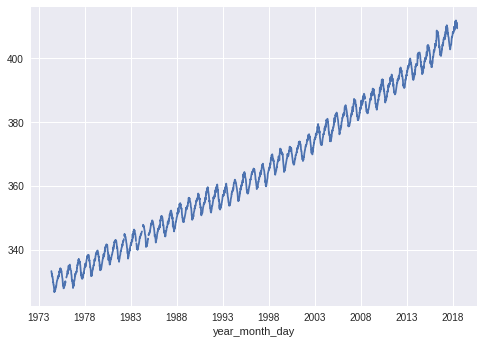

In [14]:
# Plot Co2 column
# There are some gaps in the plot due to missing values
plt.plot(maunaloa.co2)
plt.xlabel('year_month_day')
plt.show()

### Data imputation

In [15]:
# Data imputation using 'forwardfill' or 'backfill'
maunaloa.co2.isnull().sum()

20

In [16]:
# since we may not have information from future to fill the past, 
# ffill make more sense that bfill for many application
# this is possible since we set year_month_dat as index
maunaloa.fillna(method='ffill', inplace=True)
maunaloa.co2.isnull().sum()

0

### Resampling

- helpful for different granularity of data
- helpful when the data is hetrogeneous
- resampling in panda is lazy evaluation

In [17]:
# resampling is lazy
resampled_co2 = maunaloa.co2.resample('MS')
resampled_co2

DatetimeIndexResampler [freq=<MonthBegin>, axis=0, closed=left, label=left, convention=start, base=0]

In [18]:
# we need to do some analytics to the resampled data 
# say let get mean of Co2 for each month indexed with first date of the month
resampled_co2.mean().head()

year_month_day
1974-05-01    333.1450
1974-06-01    332.0280
1974-07-01    330.7125
1974-08-01    329.0725
1974-09-01    327.3240
Freq: MS, Name: co2, dtype: float64

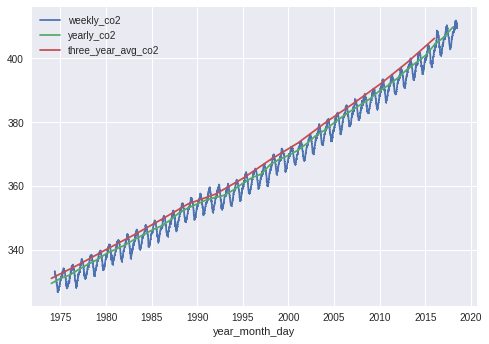

In [19]:
# Weekly averages
weekly_co2 = pd.Series(maunaloa.co2, name= 'weekly_co2')
weekly_co2.resample('W').mean().plot(marker='o', markersize=1)

# Annual start averages
yearly_co2 = pd.Series(maunaloa.co2, name='yearly_co2')
yearly_co2.resample('AS').mean().plot(marker='o', markersize=1)

# 3 year start averages
three_year_avg_co2 = pd.Series(maunaloa.co2, name='three_year_avg_co2')
three_year_avg_co2.resample('3AS').mean().plot(marker='o', markersize=1)
plt.legend()
plt.show()

The question is what frequency do we want to work, fine grain vs. coarse grain granularity to work on?

  - for this exercise let's pick weekly data


### 1D Forecasting Basics


  **Stationarity**:  Assumptions: 
  - no trend-- mean independent of time
  - variance independent of time
  - covariance of two observations `k steps` apart independent of time
 

**Explanatory Data Analysis (EDA)**

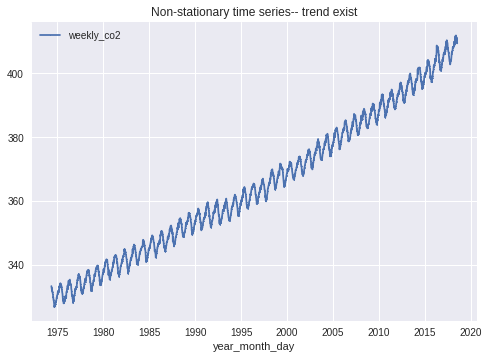

In [20]:
weekly_co2 = pd.Series(maunaloa.co2, name= 'weekly_co2')
weekly_co2.resample('W').mean().plot(marker='o', markersize=1)
plt.title('Non-stationary time series-- trend exist')
plt.legend()
plt.show()

## De-trending
For a statstical models, we need to remove the trend before apply modeling.

two methods

1.   Model the trend and subtract it
2.  Differencing (computing new series)-- computing the gradient x_t+1 - x_t




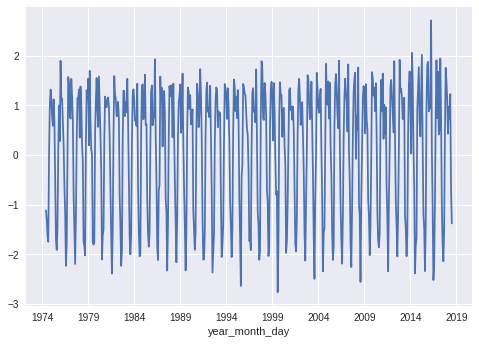

In [21]:
# differencing: mean, variance, don't change much after de-trending
# weekly_co2 = maunaloa.co2.resample('W').mean()
# weekly_co2.diff().plot()
ppm = resampled_co2.mean()
ppm.diff().plot()
plt.show()

### Autocorrelation

- how much correlation is there between time step at t and t+n

In [22]:
# Autocorrelation with a lag of 1 week
ppm.autocorr()

0.9984191478003273

In [23]:
# Autocorrelation with a lag of 12 weeks
ppm.autocorr(lag=12)

0.9996283006383987

Autocorrelation close to 1 mean, each time step is very good predicter of next time step

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


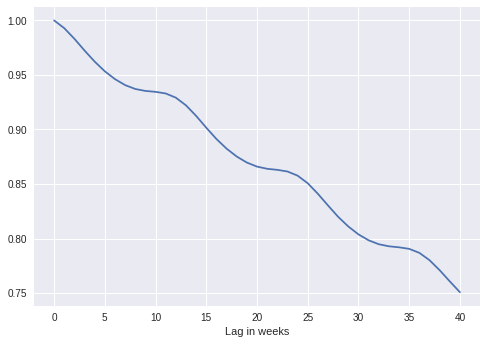

In [24]:
# looking at the autocorrelation at the same time for differnt lag time
# import tsa-- time series analsysis
from statsmodels.tsa.stattools import acf    # import acf-- autocoreelation function
autocorrelation = acf(ppm)
plt.plot(autocorrelation)
plt.xlabel('Lag in weeks')
plt.show()

In [0]:
# Using pandas autocorrelation_plot 

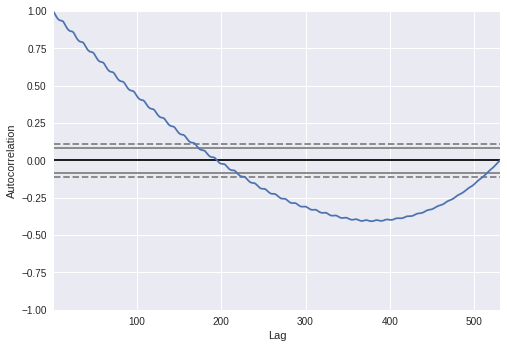

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ppm)
plt.grid()
plt.show()

Anything outside of the std bounding lines have autocorrelation

### Autocorrelation of differenced series

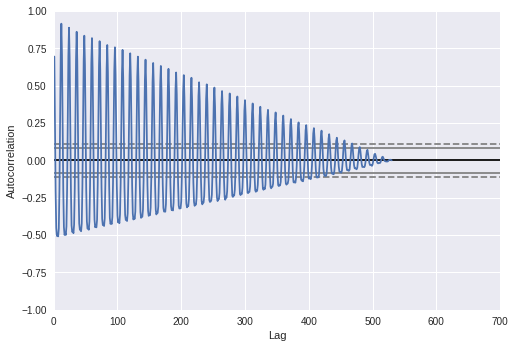

In [27]:
autocorrelation_plot(ppm.diff()[1:])
plt.xlim(0, 700)
plt.grid()
plt.show()

The autocorr from diff showd correlation and periodicity. Closer look using acf. It shows the natural weahter cycle 

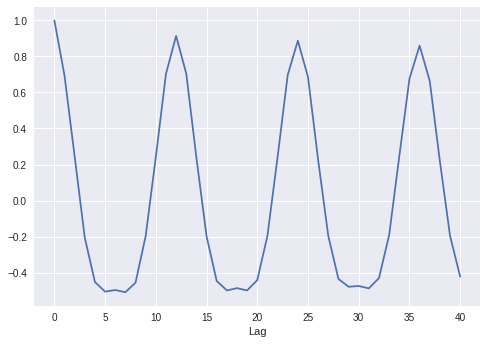

In [28]:
autocorre = acf(ppm.diff()[1:])
plt.plot(autocorre)
plt.xlabel('Lag')
plt.show()

### Seasonality model for Co2

- Decomposing the data into trend and seasonal model by smoothing
- Obseerved data = Trend + Seasonal + Noise

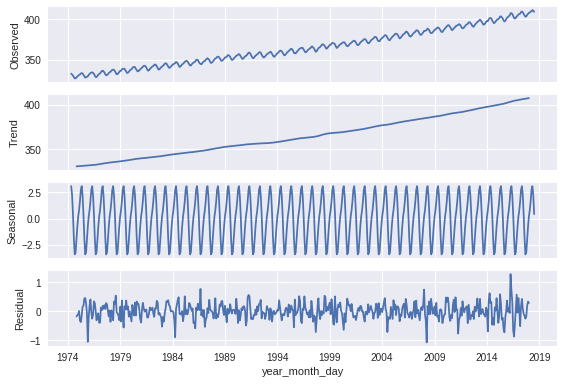

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ppm, model='additive')
fig = decomposition.plot()

**How can we make forecasting?**

## Autoregressive (linear) Model

- Order k AR model (whihc can include trend and offset) and learn coefficient `c_i` using leanst squares
- Predict the next time  step using the previoud time step by learnly weighting them

### AR models with `statsmodels`

In [30]:
from statsmodels.tsa import ar_model
ar = ar_model.AR(ppm[:300])    # use the first 500 steps for training
res = ar.fit(maxlag=12)    # use timelag of 12 weeks
res.params

const     -1.089514
L1.co2     0.912288
L2.co2    -0.208332
L3.co2    -0.167864
L4.co2    -0.022730
L5.co2     0.186448
L6.co2    -0.075572
L7.co2     0.033152
L8.co2    -0.141770
L9.co2     0.085515
L10.co2    0.031878
L11.co2    0.336368
L12.co2    0.035480
dtype: float64

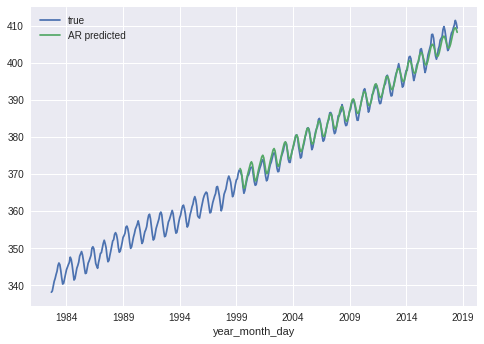

In [31]:
# plot true and predicted
ppm[100:].plot(label="true")
res.predict(ppm.index[300],
           ppm.index[-1]).plot(label='AR predicted')
plt.legend()
plt.show()

### Impact of order

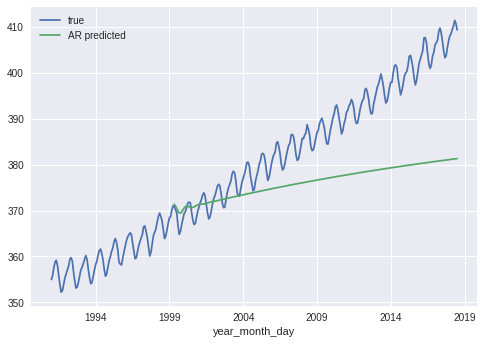

In [32]:
# Decreasing the lag time
ar6 = ar_model.AR(ppm[:300])
res6 = ar6.fit(maxlag=6)
ar_ped = res6.predict(ppm.index[300],
                     ppm.index[-1])


ppm[200:].plot(label="true")
res6.predict(ppm.index[300],
           ppm.index[-1]).plot(label='AR predicted')
plt.legend()
plt.show()

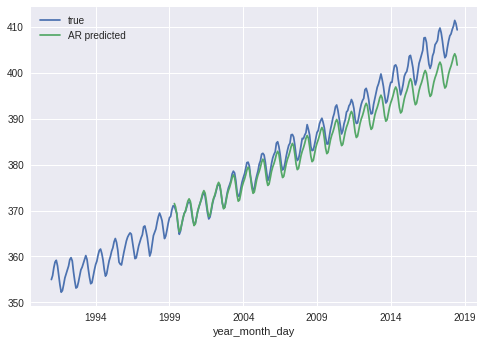

In [33]:
# Increasing the lag time
# it can use more history for prediction, near prefect prediction
# it might overfit for very maxlag
ar25 = ar_model.AR(ppm[:300])
res25 = ar25.fit(maxlag=25)
ar_ped = res25.predict(ppm.index[300],
                     ppm.index[-1])


ppm[200:].plot(label="true")
res25.predict(ppm.index[300],
           ppm.index[-1]).plot(label='AR predicted')
plt.legend()
plt.show()

Autoregressive integrated moving average (ARIMA)

- tries to built more complex stat model

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is

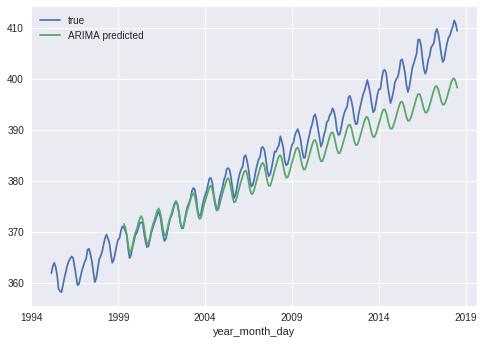

In [34]:
from statsmodels import tsa
arima_model = tsa.arima_model.ARIMA(ppm[:300], order=(12,1,0))
res_arima = arima_model.fit()
arima_pred = res_arima.predict(ppm.index[300], ppm.index[-1], typ='levels')

# plot
ppm[250:].plot(label="true")
arima_pred.plot(label='ARIMA predicted')
plt.legend()
plt.show()

### Solve it with Sklearn: 1D with sklearn

- fit it with linear model on the time

In [35]:
# Linear model for trend
train = ppm[:300]
test = ppm[300:]
# Convert time stamp to ordinal 
X = ppm.index.to_series().apply(lambda x:x.toordinal())
X = pd.DataFrame(X)
X_train, X_test = X.iloc[:300,:], X.iloc[300:,:]
X_train.shape

(300, 1)

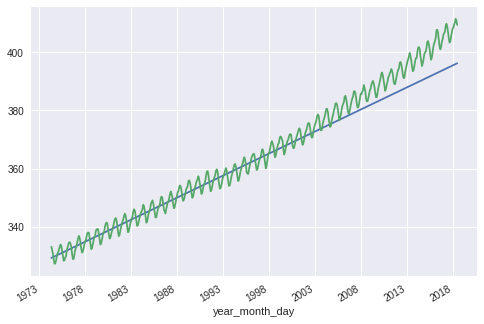

In [36]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, train)
lr_pred = lr.predict(X_test)
plt.plot(ppm.index, lr.predict(X))
ppm.plot()
plt.show()

Using polynomial features

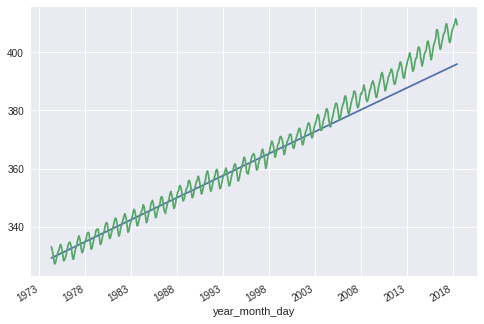

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# create feature and fit model using Pipeline
lr_poly = make_pipeline(PolynomialFeatures(degree=5, include_bias=False), 
                       LinearRegression())
lr_poly.fit(X_train, train)
plt.plot(ppm.index, lr_poly.predict(X))
ppm.plot()
plt.show()
# lr_poly

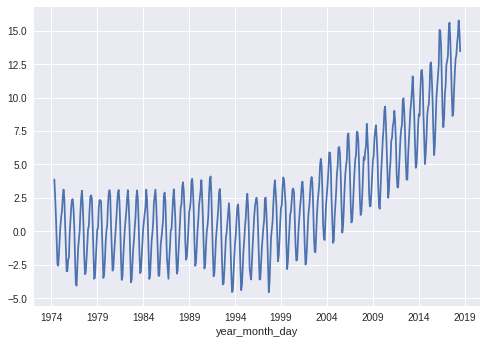

In [38]:
# Detrending with trend model

y_res = ppm - lr_poly.predict(X)
y_res.plot()
plt.show()

# still have more structure-- need to recheck

In [39]:
# AR model on residual of 1D sklearn

ar_model_res = ar_model.AR(y_res[:300])
res_res = ar_model_res.fit(maxlag=12)
ar_pred_res = res_res.predict(ppm.index[300],
                             ppm.index[-1])
res_res.params

const      0.014050
L1.co2     0.928314
L2.co2    -0.216052
L3.co2    -0.170711
L4.co2    -0.022761
L5.co2     0.187247
L6.co2    -0.082760
L7.co2     0.035795
L8.co2    -0.142542
L9.co2     0.080171
L10.co2    0.032369
L11.co2    0.343548
L12.co2    0.014416
dtype: float64

### Seasonal Forecasting with FBProphet

- A picewise linear or logistic growth curve trend
- Prophet automatically detects changes in trends by selecting changepoints from the data
- A yearly seasonal componenet modeled using Fourier series
- A weekly seasonal coponenet modeled using dummy varaiables
- A user-provided list of important holidays

Facebook's original publication [here](https://research.fb.com/prophet-forecasting-at-scale/)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


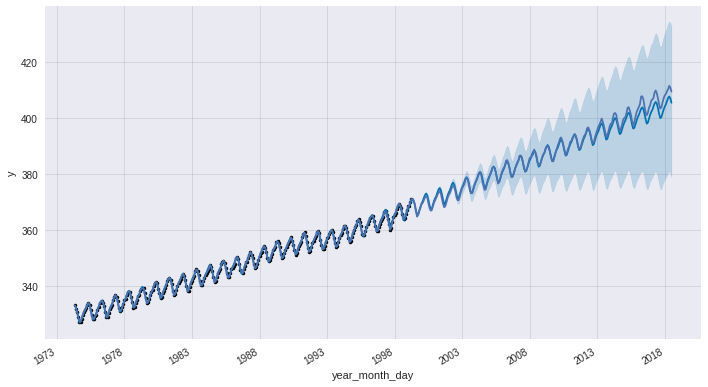

In [60]:
# Forecasting
fb_ppm = pd.DataFrame(ppm)
fb_ppm.reset_index(inplace=True)
fb_ppm.columns = ['ds','y']
m = Prophet()
m.fit(fb_ppm[:300])
forecast = m.predict(fb_ppm)

# plot results
m.plot(forecast)
ppm.plot()
plt.show()

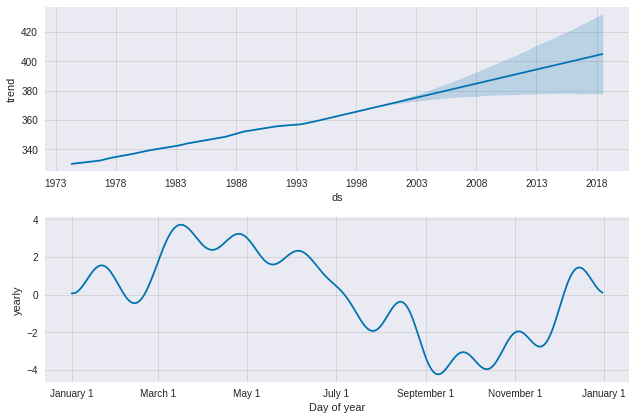

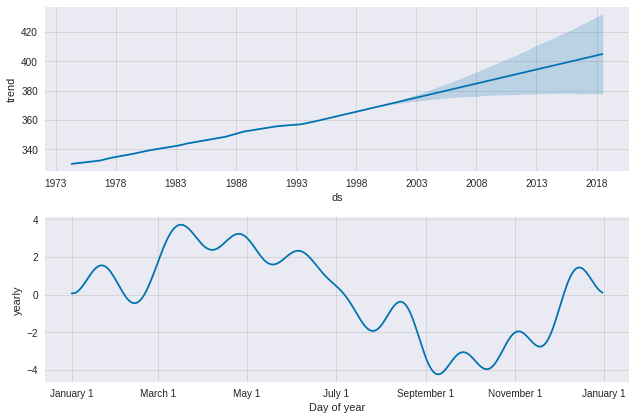

In [61]:
# Seasonality decomposition with uncertainity
m.plot_components(forecast)

Extending into the future by specifing number of days

In [66]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
660,2000-03-27
661,2000-03-28
662,2000-03-29
663,2000-03-30
664,2000-03-31


In [67]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
660,2000-03-27,372.916245,372.409400,373.429069
661,2000-03-28,372.824179,372.342419,373.285662
662,2000-03-29,372.734389,372.264961,373.200919
663,2000-03-30,372.648814,372.154930,373.117048
664,2000-03-31,372.569279,372.098185,373.052190


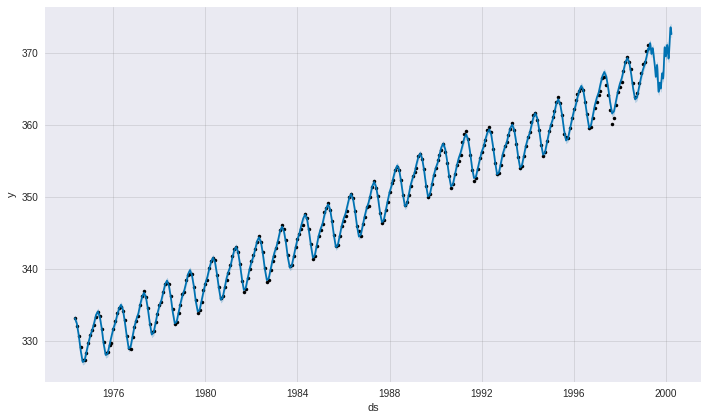

In [70]:
fig1 = m.plot(forecast)

This tutorial is based on Andreas Muller's course [here](http://www.cs.columbia.edu/~amueller/comsw4995s18/schedule/)